# Analysis and Evaluations

**Process**

1. Load crowd data 
2. Load network data
3. Calculate pairwise joint-membership matrix for both datasets
4. Evaluation metrics (Rand Index, others that consider fuzziness, see [here](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation))

In [21]:
import osmnx as ox, networkx as nx, numpy as np, geopandas as gpd, pandas as pd, matplotlib.pyplot as plt
import matplotlib.cm as cm, contextily as cx
import community
import math

from sklearn import metrics
from shapely.geometry import Point, LineString, Polygon, MultiPoint

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
epsg = 26986
city_name = 'Boston'
crs = 'EPSG:'+str(epsg)

In [3]:
# gridded data
crowd = gpd.read_file('data/grid201703.shp').to_crs(epsg)
crowd.head(10)

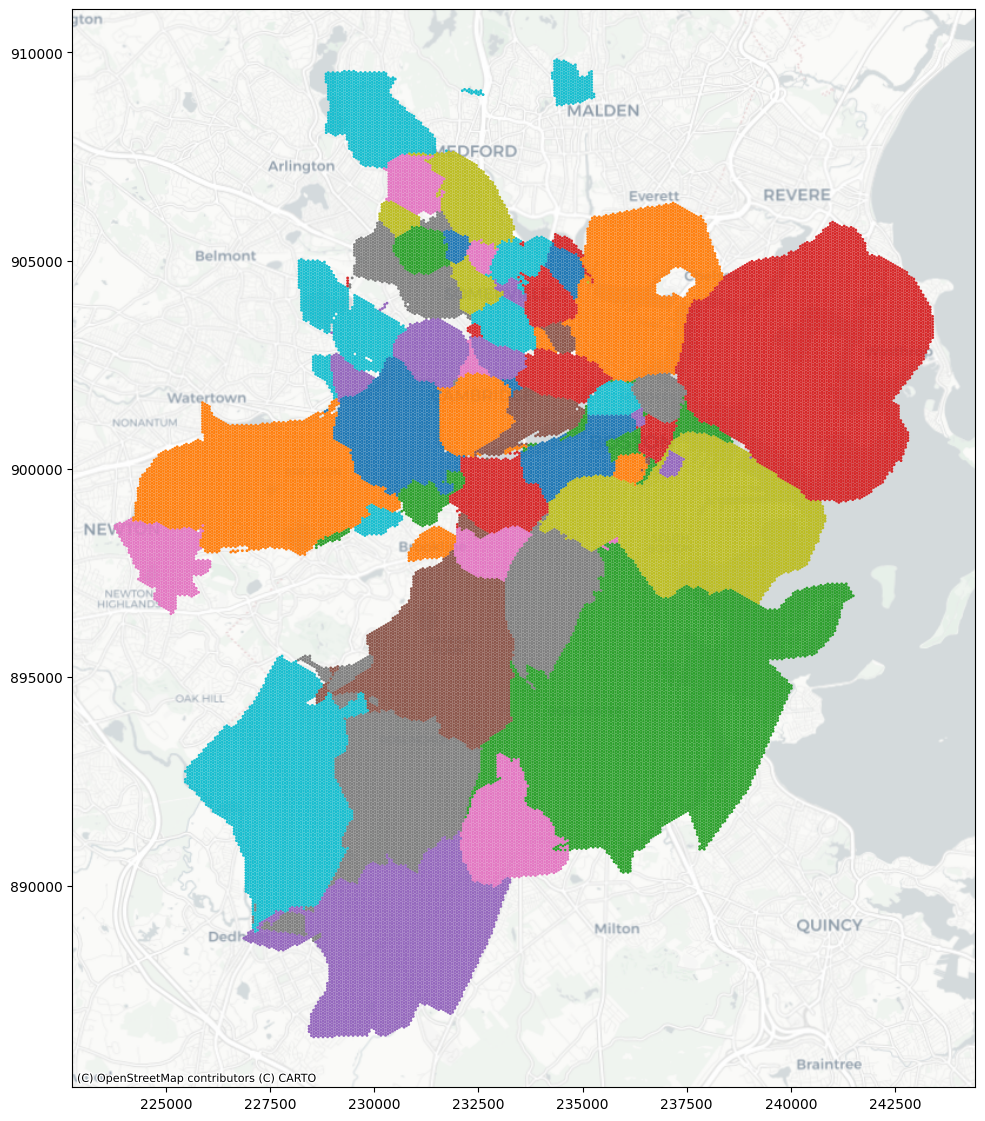

In [18]:
fig, ax = plt.subplots(figsize=(14,14))
crowd.plot(column='name', ax=ax)
cx.add_basemap(ax, crs=crowd.crs, source=cx.providers.CartoDB.Positron)

## Input Dual Communities

In [4]:
commmunities_dual = gpd.read_file('data/Boston_districts_dual.gpkg')
commmunities_dual["centroid"] = commmunities_dual.centroid
commmunities_dual.head(3)

,edgeID,u,v,key,length,highway,oneway,lanes,name,bridge,tunnel,pedestrian,sep_barr,ca,lp,wa,lo,ca_nb,lp_nb,wa_nb,lo_nb,geometry,centroid
0,1,9673,10441,0,502.109344,residential,0,None,None,None,None,0,False,19,0,0,0,7,1,1,1,"LINESTRING (239172.918 901906.431, 239184.713 ...",POINT (239300.013 901982.268)
1,4,2,10506,0,29.161331,tertiary,1,2,East Cottage Street,None,None,0,False,12,1,1,1,15,2,2,2,"LINESTRING (236305.417 896578.537, 236310.832 ...",POINT (236317.093 896569.852)
2,5,3,7743,0,75.762848,tertiary,1,2,Pond Street,None,None,0,False,12,1,1,1,15,2,2,2,"LINESTRING (236366.270 896559.324, 236368.215 ...",POINT (236356.953 896593.892)


In [5]:
def find_midpoint(x):
    return Point(list(x.coords)[math.floor(len(x.coords)/2)])

# midpoint better along line
commmunities_dual["midpoint"] = commmunities_dual.geometry.apply(find_midpoint)
commmunities_dual = commmunities_dual.set_geometry("midpoint")

### Join tables

In [8]:
road_comms_dual = gpd.sjoin(commmunities_dual, crowd, how="left", op='within')
# convert names to integer classes
road_comms_dual['name_class'] = pd.factorize(road_comms_dual['name_right'])[0].astype(np.int64)
road_comms_dual.head()

C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,edgeID,u,v,key,length,highway,oneway,lanes,name_left,bridge,tunnel,pedestrian,sep_barr,ca,lp,wa,lo,ca_nb,lp_nb,wa_nb,lo_nb,geometry,centroid,midpoint,index_right,gid,fid,name_right,count,pct,total,name_class
0,1,9673,10441,0,502.109344,residential,0,None,None,None,None,0,False,19,0,0,0,7,1,1,1,"LINESTRING (239172.918 901906.431, 239184.713 ...",POINT (239300.013 901982.268),POINT (239354.443 901948.867),7038,276952,276951.0,East Boston,12,0.444444,27,0
1,4,2,10506,0,29.161331,tertiary,1,2,East Cottage Street,None,None,0,False,12,1,1,1,15,2,2,2,"LINESTRING (236305.417 896578.537, 236310.832 ...",POINT (236317.093 896569.852),POINT (236316.549 896569.808),59952,246673,246672.0,Dorchester,26,1.000000,26,1
2,5,3,7743,0,75.762848,tertiary,1,2,Pond Street,None,None,0,False,12,1,1,1,15,2,2,2,"LINESTRING (236366.270 896559.324, 236368.215 ...",POINT (236356.953 896593.892),POINT (236367.198 896580.778),59952,246673,246672.0,Dorchester,26,1.000000,26,1
3,6,3,6191,0,180.480750,tertiary,1,2,East Cottage Street,None,None,0,False,12,1,1,1,2,3,3,3,"LINESTRING (236366.270 896559.324, 236369.743 ...",POINT (236454.257 896547.912),POINT (236466.137 896540.769),60430,247770,247769.0,Dorchester,26,1.000000,26,1
4,7,4,12,0,90.650946,tertiary,0,2,Centre Street,None,None,0,False,10,2,2,2,2,4,3,3,"LINESTRING (231971.983 896552.523, 231989.306 ...",POINT (231992.015 896593.164),POINT (231992.130 896592.336),40140,203852,203851.0,Jamaica Plain,62,0.984127,63,2


Useful similarity measures seem to revolve around the concept of mutual information. e.g. https://en.wikipedia.org/wiki/Pointwise_mutual_information

In [9]:
# get crowd predictions as array
crowd_pred = road_comms_dual.name_class.to_numpy()

### Results 
#### Entire network

In [22]:
labels = ['Clauset', 'Walktrap', 'Louvain', 'Label Prop']
columns = ['ca', 'wa','lo','lp']
for n, column in enumerate(columns): # Clauset / Walktrap / Louvain / Label Prop
    print(labels[n])
    net_pred = road_comms_dual[column].to_numpy()
    print('Rand:',metrics.adjusted_rand_score(crowd_pred, net_pred))
    print('Homogeneity:',metrics.homogeneity_score(crowd_pred, net_pred))
    print('Completeness:',metrics.completeness_score(crowd_pred, net_pred))
    print('V-Measure:',metrics.v_measure_score(crowd_pred, net_pred))
    print('Mutual Info:',metrics.adjusted_mutual_info_score(crowd_pred, net_pred, average_method='arithmetic'))
    print()

Clauset
Rand: 0.3697815214740299
Homogeneity: 0.7752508390197564
Completeness: 0.6712706319699469
V-Measure: 0.7195235343281368
Mutual Info: 0.7158428958048618

Walktrap
Rand: 0.14430203402969058
Homogeneity: 0.8723768776742322
Completeness: 0.5281743988377837
V-Measure: 0.6579796693671676
Mutual Info: 0.6442429017170844

Louvain
Rand: 0.2346431983143258
Homogeneity: 0.8805741958950852
Completeness: 0.5974637668080012
V-Measure: 0.7119048215395417
Mutual Info: 0.7051722229225436

Label Prop
Rand: 0.010354920843842319
Homogeneity: 0.9760380794606919
Completeness: 0.36413364198333514
V-Measure: 0.5303921801983574
Mutual Info: 0.38261363520065333



#### With Barrier removal

In [23]:
columns = ['ca_nb', 'wa_nb','lo_nb','lp_nb']
for n, column in enumerate(columns): # Clauset / Walktrap / Louvain / Label Prop
    print(labels[n])
    net_pred = road_comms_dual[column].to_numpy()
    print('Rand:',metrics.adjusted_rand_score(crowd_pred, net_pred))
    print('Homogeneity:',metrics.homogeneity_score(crowd_pred, net_pred))
    print('Completeness:',metrics.completeness_score(crowd_pred, net_pred))
    print('V-Measure:',metrics.v_measure_score(crowd_pred, net_pred))
    print('Mutual Info:',metrics.adjusted_mutual_info_score(crowd_pred, net_pred, average_method='arithmetic'))
    print()

Clauset
Rand: 0.3697815214740299
Homogeneity: 0.7752508390197564
Completeness: 0.6712706319699469
V-Measure: 0.7195235343281368
Mutual Info: 0.7158428958048618

Walktrap
Rand: 0.14430203402969058
Homogeneity: 0.8723768776742322
Completeness: 0.5281743988377837
V-Measure: 0.6579796693671676
Mutual Info: 0.6442429017170844

Louvain
Rand: 0.2346431983143258
Homogeneity: 0.8805741958950852
Completeness: 0.5974637668080012
V-Measure: 0.7119048215395417
Mutual Info: 0.7051722229225436

Label Prop
Rand: 0.010354920843842319
Homogeneity: 0.9760380794606919
Completeness: 0.36413364198333514
V-Measure: 0.5303921801983574
Mutual Info: 0.38261363520065333



### Visualisation

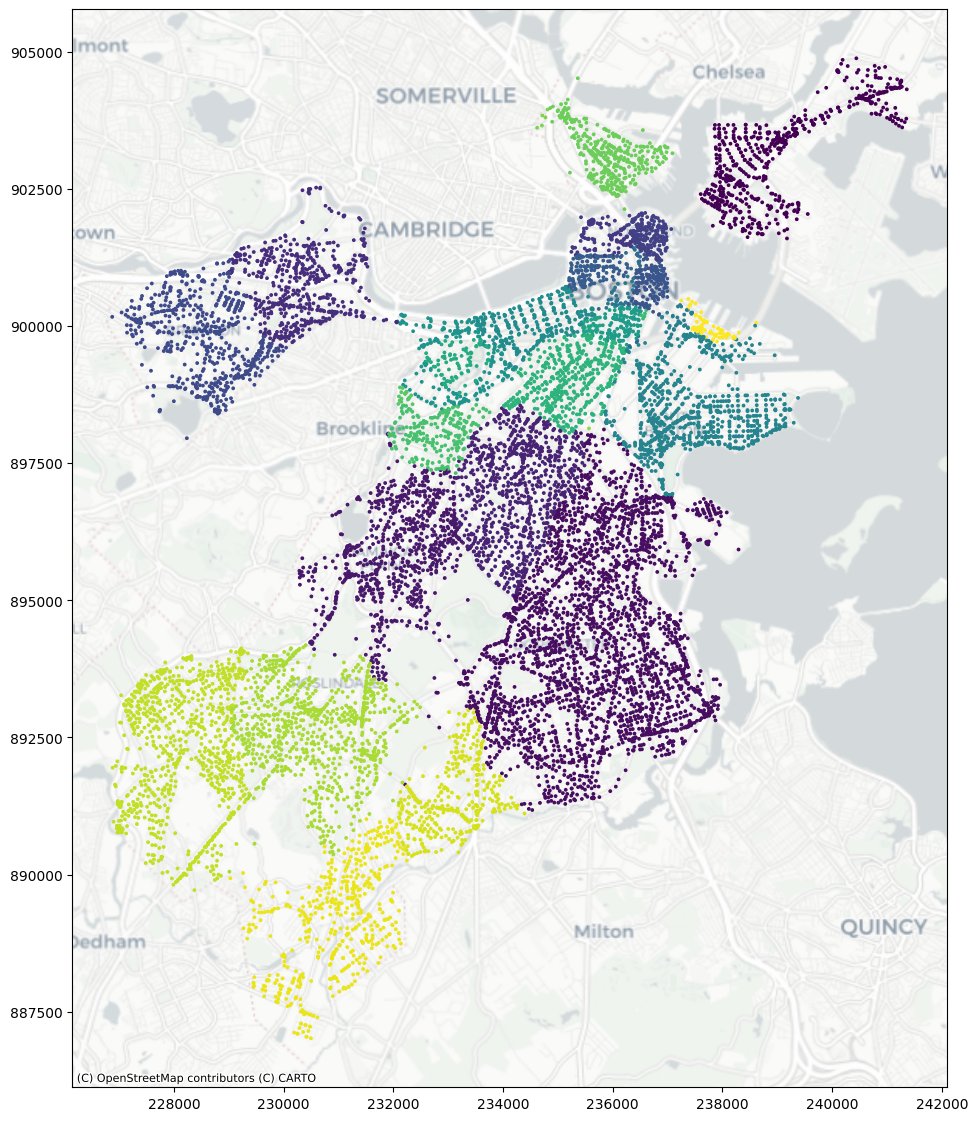

In [30]:
fig, ax = plt.subplots(figsize=(14,14))
road_comms_dual.plot(column='name_class', ax=ax, marker='o', markersize=3)
cx.add_basemap(ax, crs=road_comms_dual.crs, source=cx.providers.CartoDB.Positron)

In [32]:
ca_name_pivot = pd.pivot_table(road_comms_dual, index='name_class', columns=['ca'], values='oneway', aggfunc='count')
ca_name_pivot.head()

ca,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
name_class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,254.00,NaN,210.00,160.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.00,NaN,NaN
1,1.00,14.00,8.00,272.00,NaN,566.00,NaN,NaN,541.00,NaN,NaN,445.00,429.00,NaN,178.00,NaN,NaN,NaN,250.00,NaN,8.00,NaN,NaN,147.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36.00,NaN,NaN,165.00,NaN,1.00,NaN,NaN,NaN,NaN,424.00,NaN,NaN,5.00,NaN,NaN,NaN,112.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.00,NaN,NaN,NaN,NaN,NaN
3,NaN,143.00,NaN,324.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.00,226.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.00,NaN,NaN,311.00,NaN,NaN,NaN,NaN,252.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Input Primal Communities

In [6]:
# network data
communities_primal = gpd.read_file('data/Boston_districts_primal.gpkg')
communities_primal["centroid"] = communities_primal.centroid
communities_primal["midpoint"] = communities_primal.geometry.apply(find_midpoint)
communities_primal = communities_primal.set_geometry("midpoint")

### Join Tables

In [24]:
road_comms_primal = gpd.sjoin(communities_primal, crowd, how="left", op='within')
# convert names to integer classes
road_comms_primal['name_class'] = pd.factorize(road_comms_primal['name_right'])[0].astype(np.int64)
road_comms_primal.head()

C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,edgeID,u,v,key,length,highway,oneway,lanes,name_left,bridge,tunnel,pedestrian,sep_barr,ca_uv,ca_u,ca_v,lp_uv,lp_u,lp_v,wa_uv,wa_u,wa_v,lo_uv,lo_u,lo_v,ca_nb_uv,ca_nb_u,ca_nb_v,lp_nb_uv,lp_nb_u,lp_nb_v,wa_nb_uv,wa_nb_u,wa_nb_v,lo_nb_uv,lo_nb_u,lo_nb_v,geometry,centroid,midpoint,index_right,gid,fid,name_right,count,pct,total,name_class
0,1,9673,10441,0,502.11,residential,0,None,None,None,None,0,False,4,4,4,1624,1624,1624,29,29,29,41,41,41,30.00,30.00,30.00,"1,494.00","1,494.00","1,494.00",19.00,19.00,19.00,9.00,9.00,9.00,"LINESTRING (239172.918 901906.431, 239184.713 ...",POINT (239300.013 901982.268),POINT (239354.443 901948.867),7038,276952,"276,951.00",East Boston,12,0.44,27,0
1,4,2,10506,0,29.16,tertiary,1,2,East Cottage Street,None,None,0,False,7,7,7,0,0,0,0,0,0,0,0,0,9.00,9.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"LINESTRING (236305.417 896578.537, 236310.832 ...",POINT (236317.093 896569.852),POINT (236316.549 896569.808),59952,246673,"246,672.00",Dorchester,26,1.00,26,1
2,5,3,7743,0,75.76,tertiary,1,2,Pond Street,None,None,0,False,7,7,7,999999,0,702,999999,0,213,0,0,0,9.00,9.00,9.00,"999,999.00",0.00,668.00,"999,999.00",0.00,135.00,0.00,0.00,0.00,"LINESTRING (236366.270 896559.324, 236368.215 ...",POINT (236356.953 896593.892),POINT (236367.198 896580.778),59952,246673,"246,672.00",Dorchester,26,1.00,26,1
3,6,3,6191,0,180.48,tertiary,1,2,East Cottage Street,None,None,0,False,7,7,7,999999,0,15,0,0,0,0,0,0,9.00,9.00,9.00,"999,999.00",0.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,"LINESTRING (236366.270 896559.324, 236369.743 ...",POINT (236454.257 896547.912),POINT (236466.137 896540.769),60430,247770,"247,769.00",Dorchester,26,1.00,26,1
4,7,4,12,0,90.65,tertiary,0,2,Centre Street,None,None,0,False,27,27,27,999999,1,6,1,1,1,1,1,1,23.00,23.00,23.00,"999,999.00",1.00,6.00,1.00,1.00,1.00,1.00,1.00,1.00,"LINESTRING (231971.983 896552.523, 231989.306 ...",POINT (231992.015 896593.164),POINT (231992.130 896592.336),40140,203852,"203,851.00",Jamaica Plain,62,0.98,63,2


### Results 
#### Entire network

In [26]:
labels = ['Clauset', 'Walktrap', 'Louvain', 'Label Prop']
columns = ['ca_uv', 'wa_uv','lo_uv','lp_uv']
for n, column in enumerate(columns): # Clauset / Walktrap / Louvain / Label Prop
    print(labels[n])
    net_pred = road_comms_primal[column].to_numpy()
    print('Rand:',metrics.adjusted_rand_score(crowd_pred, net_pred))
    print('Homogeneity:',metrics.homogeneity_score(crowd_pred, net_pred))
    print('Completeness:',metrics.completeness_score(crowd_pred, net_pred))
    print('V-Measure:',metrics.v_measure_score(crowd_pred, net_pred))
    print('Mutual Info:',metrics.adjusted_mutual_info_score(crowd_pred, net_pred, average_method='arithmetic'))
    print()

Clauset
Rand: 0.34997962148067946
Homogeneity: 0.807626212810626
Completeness: 0.6508137571456831
V-Measure: 0.7207896941337509
Mutual Info: 0.7168818483774609

Walktrap
Rand: 0.038604622823261533
Homogeneity: 0.725236061148884
Completeness: 0.4095961184103539
V-Measure: 0.5235203599763463
Mutual Info: 0.4781753397706859

Louvain
Rand: 0.1906340334178001
Homogeneity: 0.7871516715814814
Completeness: 0.5436887661265859
V-Measure: 0.6431507624064148
Mutual Info: 0.6350117906528111

Label Prop
Rand: 0.004444906142006854
Homogeneity: 0.5979180093868687
Completeness: 0.3370715144929968
V-Measure: 0.43110884949886397
Mutual Info: 0.28582347010210846



#### With Barrier removal

In [29]:
columns = ['ca_nb_uv', 'wa_nb_uv','lo_nb_uv','lp_nb_uv']
for n, column in enumerate(columns): # Clauset / Walktrap / Louvain / Label Prop
    print(labels[n])
    net_pred = road_comms_primal[column].to_numpy()
    print('Rand:',metrics.adjusted_rand_score(crowd_pred, net_pred))
    print('Homogeneity:',metrics.homogeneity_score(crowd_pred, net_pred))
    print('Completeness:',metrics.completeness_score(crowd_pred, net_pred))
    print('V-Measure:',metrics.v_measure_score(crowd_pred, net_pred))
    print('Mutual Info:',metrics.adjusted_mutual_info_score(crowd_pred, net_pred, average_method='arithmetic'))
    print()

Clauset
Rand: 0.26570061479000234
Homogeneity: 0.7543432977184024
Completeness: 0.5996129280299448
V-Measure: 0.6681368051388759
Mutual Info: 0.6622462403319872

Walktrap
Rand: 0.0688394428997489
Homogeneity: 0.6897685815655881
Completeness: 0.4463934275442272
V-Measure: 0.542014534667691
Mutual Info: 0.5118289072785901

Louvain
Rand: 0.16324204838959339
Homogeneity: 0.7392451669480139
Completeness: 0.5387658550670436
V-Measure: 0.6232810947857906
Mutual Info: 0.6143743006738412

Label Prop
Rand: 0.004426276108267381
Homogeneity: 0.5399860663999682
Completeness: 0.3340927610195379
V-Measure: 0.41278985413305513
Mutual Info: 0.27002495787042546

